In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from skimage.feature import hog
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import time

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r0974272, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [3]:
!pip install pinscrape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.3.2
    Uninstalling charset-normalizer-3.3.2:
      Successfully uninstalled charset-normalizer-3.3.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
  Attempting uninstall: requests
    Found existing installation: req

In [57]:
# We add new images from the pinterest 
DIR_A = "mila_extra_images_A"
DIR_B = "jesse_extra_images_B"
# from pinscrape import pinscrape
# _ = pinscrape.scraper.scrape("mila kunis face", DIR_A, {}, 20, 30)
# _ = pinscrape.scraper.scrape("jesse eisenberg face", DIR_B, {}, 20, 30)

def easy_load(dir, name):
    data = []
    for filename in os.listdir(dir):
            img_path = os.path.join(dir, filename)
            print(img_path)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image loaded successfully
                if name == "Mila_Kunis":
                    data.append([name, 2, img])
                else:
                    data.append([name, 1, img])
                    
    return pd.DataFrame(data, columns=["name", "class", "img"])
        
df_mila = easy_load(DIR_A, "Mila_Kunis")
df_jesse = easy_load(DIR_B, "Jesse_Eisenberg")

mila_extra_images_A/9c0ef91114799df9e88aa4010631fdea.jpg
mila_extra_images_A/8e81c732e86edcf1a561087ec51a86ff.jpg
mila_extra_images_A/f56c1b4bcc0be968e4cedb72cea1222d.jpg
mila_extra_images_A/0ab94aa115cd8b2cb57704b70bfc4879.jpg
mila_extra_images_A/26d9860146fd4738b88d507b6e7bb9dc.jpg
mila_extra_images_A/c3ded31355d015480ba338fa39fa5646.jpg
mila_extra_images_A/2575fe99a678ab6e33f34a7ba23453ca.jpg
mila_extra_images_A/8b6caacf4ad908c0c497ea74f8268ad7.jpg
mila_extra_images_A/bb7af189a4d86ac139ec4bedf981e44b.jpg
mila_extra_images_A/f390a34a0c543417ecab00fd1e069f64.jpg
mila_extra_images_A/f14c8351463644ee866f1adecd6750a6.jpg
mila_extra_images_A/3b9b304a4de79df7928b0b85e890d612.jpg
mila_extra_images_A/78230f944814f58f0f5090e43b47f3c4.jpg
mila_extra_images_A/4515bc436129368c1f9886836821befa.jpg
mila_extra_images_A/d1415f64ccd4c173f0367fa3162c14ef.jpg
mila_extra_images_A/84f8ea6daf7a66ac930bf46707adb84d.jpg
mila_extra_images_A/f5ddd01bced98b8ccc3fbd9fa56a48d1.png
mila_extra_images_A/3ed7d8db299

In [61]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

In [59]:
train.head(10)

,name,class,img
id,,,
0,Mila_Kunis,2,"[[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4..."
1,Mila_Kunis,2,"[[[24, 35, 31], [25, 36, 32], [27, 36, 33], [2..."
2,Michael_Cera,0,"[[[111, 112, 106], [111, 112, 106], [112, 113,..."
3,Mila_Kunis,2,"[[[223, 223, 223], [223, 223, 223], [223, 223,..."
4,Michael_Cera,0,"[[[195, 195, 205], [195, 195, 205], [190, 192,..."
5,Jesse_Eisenberg,1,"[[[38, 37, 43], [38, 37, 43], [38, 37, 43], [4..."
6,Mila_Kunis,2,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
7,Jesse_Eisenberg,1,"[[[2, 10, 33], [2, 10, 33], [2, 10, 33], [2, 1..."
8,Mila_Kunis,2,"[[[2, 0, 3], [2, 0, 3], [2, 0, 3], [2, 0, 1], ..."


*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

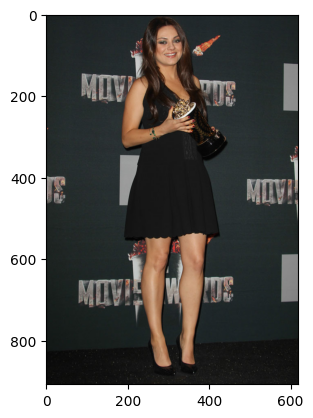

In [35]:
# The training set contains an identifier, name, image information and class label
train.head(5)
plt.imshow(train.loc[1,'img'])

In [ ]:
# The test set only contains an identifier and corresponding image information.

test.head(0)

In [62]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})
index = [14, 23, 24, 28, 35, 40, 49, 57, 64, 65]
train.drop(train.index[index], inplace=True) # some images are corrupted that'y why I remove them manually
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,26,1
Michael_Cera,10,0
Mila_Kunis,24,2
Sarah_Hyland,10,0


In [63]:
train = train._append(df_mila)
train = train._append(df_jesse)
train.groupby('name').agg({'img':'count', 'class': 'max'})

'The updated training set contains 80 examples, the test set contains 1816 examples.'

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [66]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [67]:
# parameter to play with 
FACE_SIZE = (160, 160) #100 -> 90 -> 75

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



/tmp/ipykernel_33/4005177570.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


In [68]:
print(len(train_X))

106


In [ ]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X, n=70, imgs_per_row=10)

In [ ]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=27, imgs_per_row=9) #change it to 27 after the deletion

In [ ]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=27, imgs_per_row=9) #change it to 27 after the deletion

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

In [ ]:
from skimage.util import random_noise
from skimage.transform import rotate
from skimage.transform import warp, AffineTransform

def apply_clockwise_rotation(images, angle=45):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = rotate(image, angle=angle)
        augmented_data_list.append(augmented_data)
    return augmented_data_list

clock_wise_rotation = apply_clockwise_rotation(train_X)

def apply_anticlockwise_rotation(images, angle=45):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = rotate(image, angle=-angle)
        augmented_data_list.append(augmented_data)
    return augmented_data_list
anticlockwise_rotated_images = apply_anticlockwise_rotation(train_X)

def apply_vertical_flip(images):
    augmented_data_list = []
    for image in images:
        augmented_data = np.flipud(image)
        augmented_data_list.append(augmented_data)
    return augmented_data_list

vertical_flip_images = apply_vertical_flip(train_X)



In [ ]:
augmented_train_X = np.concatenate([
    train_X,
    anticlockwise_rotated_images,
    clock_wise_rotation,
], axis=0) 
augmented_y = [item for sublist in np.tile(train_y, (3, 1))  for item in sublist]

In [ ]:
print(len(augmented_train_X))
print(len(augmented_y))

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

temp: 8 x 8 pixel cells, 16 x 16 cells, 2 x 2 cell blocks -> 15x15 == 225
single block vector = 4 * 9 = 36
225 * 36 = 8100

In [72]:
class HOGFeatureExtractor():

    def __init__(self, cell_size=(4, 4), block_size=(4, 4), nbins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins

    def transform(self, faces: np.ndarray):

        all_features = []
        visual_hog_representations = []
        for face in faces:
            face = np.array(face, dtype='uint8')
            face = cv2.resize(face, (FACE_SIZE))
            fd, hog_image = hog(face, orientations=self.nbins, pixels_per_cell=self.cell_size,
                                cells_per_block=self.block_size, visualize=True, channel_axis=2, transform_sqrt=False)

            all_features.append(fd)
            visual_hog_representations.append(hog_image)
        return all_features, visual_hog_representations

    def __call__(self, X):
        return self.transform(X)


extractor = HOGFeatureExtractor()
# other_hog_feature_descriptors, other_hog_representations = extractor(
#     train_X[train_y == 0])
# jesse_hog_feature_descriptors, jesse_hog_representations = extractor(
#     train_X[train_y == 1])
# mila_hog_feature_descriptors, mila_hog_representations = extractor(
#     train_X[train_y == 2])

# hog_feature_descriptors = [*other_hog_feature_descriptors, *jesse_hog_feature_descriptors, *mila_hog_feature_descriptors]

# plot_image_sequence(mila_hog_representations,
#                     len(mila_hog_representations), 9)

### 1.1.1. t-SNE Plots
...

In [ ]:
tsne = TSNE(n_components=3, perplexity=30)

tnse_result = tsne.fit_transform(
    np.array(hog_feature_descriptors))


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tnse_result[:, 0]
ty = tnse_result[:, 1]


fig = plt.figure()
ax = fig.add_subplot(111)


# class other
current_tx = tx[:len(other_hog_feature_descriptors)]
current_ty = ty[:len(other_hog_feature_descriptors)]
color = np.array((255, 0, 0), dtype=np.float32) / 255
ax.scatter(current_tx, current_ty, color=color, label='other')

# class jesse
current_tx = tx[len(other_hog_feature_descriptors):len(
    jesse_hog_feature_descriptors) + len(other_hog_feature_descriptors)]
current_ty = ty[len(other_hog_feature_descriptors):len(
    jesse_hog_feature_descriptors) + len(other_hog_feature_descriptors)]
color = np.array((0, 255, 0), dtype=np.float32) / 255
ax.scatter(current_tx, current_ty, color=color, label='jesse')

# class mila
current_tx = tx[len(
    jesse_hog_feature_descriptors) + len(other_hog_feature_descriptors):]
current_ty = ty[len(
    jesse_hog_feature_descriptors) + len(other_hog_feature_descriptors):]
color = np.array((0, 0, 255), dtype=np.float32) / 255
ax.scatter(current_tx, current_ty, color=color, label='mila')

plt.show()

### 1.1.2. Discussion
...

In [ ]:
print(tnse_result[0])

## 1.2. Baseline 2: PCA feature extractor
...

In [ ]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, identity, n_components, FACE_SIZE):
        super().__init__()
        self.n_components = n_components
        self.w = FACE_SIZE[0]
        self.h = FACE_SIZE[1]

    def picturesToGrayScale(self, X):
        grayscale_images = np.empty((X.shape[0], X.shape[1], X.shape[2]) , dtype=int)
        for i, img_matrix in enumerate(train_X):
            img_matrix = img_matrix.astype(np.uint8)
            imgFrame = cv2.cvtColor(img_matrix, cv2.COLOR_BGR2GRAY)
            grayscale_images[i] = imgFrame
        return grayscale_images

    def getMean(self, grayX):
        mean_img_frame = np.mean(grayX, axis = 0)
        mean_img_frame = mean_img_frame.astype(np.uint8)
        return mean_img_frame 

    def getCenteredImage(self, grayX, meanX):
        img_frames_centered = grayX - meanX
        return img_frames_centered

    def getImageMatrix(self, centeredX):
        return(np.reshape(centeredX, (centeredX.shape[0], self.w * self.h)))

    def pCA(self, X2d):
        pca = PCA(n_components=self.n_components)
        pca.fit_transform(X2d)
        return(pca)

    def plotExplainedVariance(self, pca):
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(1, self.n_components + 1), pca.explained_variance_ratio_)
        plt.title("Explained Variance per Eigenface")
        plt.xlabel('Eigenfaces')
        plt.ylabel('Explained Variance')
        
        plt.show()

    def plotEigenfaces(self, pca):
        fig = plt.figure(figsize=(10, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        for i in range(20):
            ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
            ax.imshow(np.reshape(pca.components_[i,:], (self.h, self.w)), cmap=plt.cm.bone, interpolation='nearest')

        plt.show()

    def plotReconstructFace(self, kEigenfaces, pictureIndex, grayX, meanX, X2d, pca):
        # a vector of k coefficients, one for each of the k eigenfaces (for different values of k)
        face_coeffs = np.dot(X2d[pictureIndex], pca.components_[:kEigenfaces].T)
        reconstructed_face = np.dot(face_coeffs, pca.components_[:kEigenfaces]) + meanX.flatten()
        array_2d = np.reshape(reconstructed_face, (self.h, self.w))
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(np.reshape(grayX[pictureIndex], (self.h, self.w)), cmap=plt.cm.bone, interpolation='nearest')
        axes[0].set_title(f'Original (#{pictureIndex})')
        axes[1].imshow(array_2d, cmap=plt.cm.bone, interpolation='nearest')
        axes[1].set_title(f'Reconstruction with {kEigenfaces} Eigenfaces')
        
        plt.show()

    def plotSequentialReconstructFace(self, pictureIndex, grayX, meanX, X2d, pca):
        reconstructedFaces = []
        counter = 0
        for kEigenfaces in range(1, self.n_components + 1, 5):
        # a vector of k coefficients, one for each of the k eigenfaces (for different values of k)
            face_coeffs = np.dot(X2d[pictureIndex], pca.components_[:kEigenfaces].T)
            reconstructed_face = np.dot(face_coeffs, pca.components_[:kEigenfaces]) + meanX.flatten()
            array_2d = np.reshape(reconstructed_face, (self.h, self.w))
            reconstructedFaces.append(array_2d)
            counter += 1 
        
        fig = plt.figure(figsize=(10, 8))
        fig.suptitle('Sequential Reconstruction of Face', fontsize=16)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9, hspace=0.2, wspace=0.05)
        
        for i in range(counter):
            ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
            ax.imshow(reconstructedFaces[i], cmap=plt.cm.bone, interpolation='nearest')
            ax.set_title('Eigenfaces = {}'.format((i+1)*5))

        plt.show()
        

    def plotReconstructionError(self, pictureIndex, grayX, meanX, X2d, pca):

        total_reconstruction_errors = np.zeros(self.n_components)
        for pictureIndex in range(0, X2d.shape[0]):
            reconstruction_errors = []
            for kEigenfaces in range(1, self.n_components + 1):
                face_coeffs = np.dot(X2d[pictureIndex], pca.components_[:kEigenfaces].T)
                reconstructed_face = np.dot(face_coeffs, pca.components_[:kEigenfaces]) + meanX.flatten()
                residual = np.linalg.norm(grayX[pictureIndex].flatten() - reconstructed_face)
                reconstruction_errors.append(residual)
            total_reconstruction_errors += np.array(reconstruction_errors)

        avg_reconstruction_errors = total_reconstruction_errors / X2d.shape[0]

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.n_components + 1), avg_reconstruction_errors, marker='o')
        plt.xlabel('Number of Eigenfaces')
        plt.ylabel('Reconstruction Error')
        plt.title('Reconstruction Error per Number of Eigenfaces')
        plt.grid(True)
        
        plt.show()

    def plotFeatureSpace(self, grayX, pca, X2d, train_y):

        coordinates_x = []
        coordinates_y = []

        for index in range(1, grayX.shape[0]):
            face_coeffs = np.dot(X2d[index], pca.components_[:2].T)
            coordinates_x.append(face_coeffs[0])
            coordinates_y.append(face_coeffs[1])

        plt.figure(figsize=(12, 12))

        for x, y, img in zip(coordinates_x, coordinates_y, grayX):
            plt.imshow(img, extent=(x - 400, x , y - 400, y), cmap='gray', alpha=0.7)
            #color = "red" if train_y == 0 else "green" if train_y == 1 else "blue"
            #plt.scatter(x,y, color = color)

        for x, y, train_y_label in zip(coordinates_x, coordinates_y, train_y):
            color = "red" if train_y_label == 0 else "green" if train_y_label == 1 else "blue"
            #label = "Michael and Sarah" if train_y_label == 0 else "Jesse" if train_y_label == 1 else "Mila" 
            plt.scatter(x, y, color=color)

        legend_handles = [
            mpatches.Patch(color='red', label='Michael and Sarah'),
            mpatches.Patch(color='green', label='Jesse'),
            mpatches.Patch(color='blue', label='Mila'),
        ]

        plt.xlim(np.min(coordinates_x) - 400, np.max(coordinates_x) + 100)
        plt.ylim(np.min(coordinates_y) - 400, np.max(coordinates_y) + 100)
        plt.xlabel('Eigenface 1')
        plt.ylabel('Eigenface 2')
        plt.title('Feature Space plot')
        plt.grid(True)
        plt.legend(handles=legend_handles)

        plt.show()

In [ ]:
identity = IdentityFeatureExtractor()
n_components = train_X.shape[0]
pcaFeatureExtractor = PCAFeatureExtractor(identity, n_components, FACE_SIZE)
grayX = pcaFeatureExtractor.picturesToGrayScale(train_X)
meanX = pcaFeatureExtractor.getMean(grayX)
centeredX = pcaFeatureExtractor.getCenteredImage(grayX, meanX)
X2d = pcaFeatureExtractor.getImageMatrix(centeredX)
pca = pcaFeatureExtractor.pCA(X2d)

### 1.2.1. Eigenface Plots
...

In [ ]:
pcaFeatureExtractor.plotEigenfaces(pca)

### 1.2.2. Feature Space Plots
#### One Reconstruction 

Here you can try to reconstruct any face you want to, just change the second parameter in the function to the index of the desired picture. 
In addition the Number of Eigenfaces can also be adapted. Play a little bit with the first parameter and notice that the reconstructed face approximates the original Face with increasing Eigenface number. 

In [ ]:
pcaFeatureExtractor.plotReconstructFace(65, 0, grayX, meanX, X2d, pca)

#### Sequential Reconstruction

By now you must have noticed that the Reconstruction gets better with increasing number of Eigenfaces. If you still don't believe it, have a look at the following plot!  

In [ ]:
pcaFeatureExtractor.plotSequentialReconstructFace(0, grayX, meanX, X2d, pca)

### 1.2.3. Discussion
Let's quickly dive into some statistics. When applying PCA we ultimately aim to reduce the dimensionality of the data we have an information loss, that varies from Eigenvector to Eigenvector depending on the Eigenvalue. Inversely, we can say that each Eigenvector explains to a certain extend, depending on its Eigenvalue, the variance of the data. With regard to the first Figure, the first Eigenface captures almost 25% of all information, whereas the second most relevant Eigenface explains roughly 18% of the Variance, and so on. This analysis helps us setting a cut-off. 
Further, with respect to Figure 2, the reconstruction error decreases with increasing number of Eigenfaces. 

In [ ]:
pcaFeatureExtractor.plotExplainedVariance(pca)
pcaFeatureExtractor.plotReconstructionError(3, grayX, meanX, X2d, pca)

### 1.2.4 Feature Space Plots

In [ ]:
# Add here color to the pictures 
pcaFeatureExtractor.plotFeatureSpace(grayX, pca, X2d, train_y)

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [69]:
from sklearn import svm

class mySVMClassifier:    
    def fit(self, X, y):
        param_grid = [
                {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                {'kernel': ['rbf'], 'gamma': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6], 'gamma': [0.001, 0.01, 0.1], 'coef0': [0, 1, -1], 'C': [0.1, 1, 10]},
]
        svm_model = svm.SVC() 
        grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # 5-fold cross-validation
        grid_search.fit(X, y) 
        self.model =  grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
        
    def __call__(self, X):
        return self.predict(X)

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
xgb.config_context(use_rmm=True)

class myXGBoostClassifier:

    def fit(self, X, y):

        param_grid = {
            'learning_rate': [0.05, 0.1, 0.3, 0.5] ,
            'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],  
            'max_depth': [1 ,2, 5] 
        }

        xgb_model = XGBClassifier(verbosity='1', 
                                  device='cuda',
                                  subsample = 0.8,
                                  colsample_bytree = 0.8,
                                  objective='binary:logistic', 
                                  n_estimators=100, 
                                  min_child_weight = 1,
                                 ) 
        grid_search = GridSearchCV(xgb_model, param_grid, cv=5) 
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self
    
    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """

        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""

        return self.predict(X)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

class myKNNClassifier:
    """A class for an XGBoost classifier, with hyperparameter tuning."""

    def fit(self, X, y):

        param_grid = dict(n_neighbors=list(range(1, 50)))
        neigh = KNeighborsClassifier()
        
        grid_search = GridSearchCV(neigh, param_grid, cv=10) 
        grid_search.fit(X, y)  
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self
    
    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """

        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""

        return self.predict(X)


In [ ]:
from sklearn.linear_model import LogisticRegression

class myLogisticRegressionClassifier:
    """A class for a Logistic Regression classifier, with hyperparameter tuning."""

    def fit(self, X, y):
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'class_weight': ['balanced', None],
        }

        logreg = LogisticRegression(solver='liblinear')
        grid_search = GridSearchCV(logreg, param_grid, cv=10)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self

    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """
        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""
        return self.predict(X)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

class myRandomForestClassifier:
    def fit(self, X, y):
        param_grid = {
            'n_estimators': [1, 2 ,3 ,4 , 5],
            'max_depth': [3, 5, 8, 10, None],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy'],
        }

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=10)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self
    
    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """
        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""
        return self.predict(X)

In [70]:
class CustomPipeline:
    def __init__(self, category):
        self.category = category
    
    def train_pipeline(self, model, x_train, y_train):
        self.model = model.fit(x_train, y_train)
        
    def predict_pipeline(self, y):
        mlm = lambda X: self.model(X)
        self.results = mlm(y)
    
    def save_results(self):
        x = time.time()
        submission = test.copy().drop('img', axis = 1)
        submission['class'] = self.results
        submission.to_csv(f'{self.category}_submission_{x}.csv')

In [73]:
# inputData,_ = extractor(augmented_train_X)
# testData, _ = extractor(test_X)
inputData,_ = extractor(train_X)
testData, _ = extractor(test_X)

In [ ]:
knnPipeline = CustomPipeline(category= "KNN")
knnClass = myKNNClassifier()
knnPipeline.train_pipeline(knnClass, inputData, augmented_y)
knnPipeline.predict_pipeline(testData)
knnPipeline.save_results()

In [ ]:
lgrPipeline = CustomPipeline(category= "LGR")
lgClass= myLogisticRegressionClassifier()
lgrPipeline.train_pipeline(lgClass, inputData, augmented_y)
lgrPipeline.predict_pipeline(testData)
lgrPipeline.save_results()

In [ ]:
rfPipeline = CustomPipeline(category= "RF")
rfClass= myRandomForestClassifier()
rfPipeline.train_pipeline(lgClass, inputData, augmented_y)
rfPipeline.predict_pipeline(testData)
rfPipeline.save_results()

In [ ]:
input_,_ = extractor(augmented_train_X)
rf = myRandomForestClassifier()
rf.fit(input_, augmented_y)
model = lambda X: rf(extractor(X)[0])
predictions = model(test_X)

In [74]:
svmPipeline = CustomPipeline(category= "SVM")
svmClass= mySVMClassifier()
svmPipeline.train_pipeline(svmClass, inputData, train_y)
svmPipeline.predict_pipeline(testData)
svmPipeline.save_results()

Best params: {'C': 0.01, 'kernel': 'linear'}
Best score: 0.7727272727272727


In [76]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

pca = PCA()
svm_model = SVC() 
scaler = MaxAbsScaler()
param_grid = {
    "pca__n_components": [4, 10, 20,  30, 50 , 56],    
    'svm__kernel': ['rbf'], 
    'svm__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10]
}
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("svm", svm_model)])

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(inputData,train_y)
model = search.best_estimator_
predictions = search.predict(testData)


In [ ]:
# Required cuda to run it, don't run it if you haven't change your accelerator to GPU
# import cupy
# xgboostPipeline = CustomPipeline(category= "XGBOOST")
# xgbClass= myXGBoostClassifier()
# xgboostPipeline.train_pipeline(xgbClass, cupy.array(inputData), augmented_y)
# xgboostPipeline.predict_pipeline(testData)
# xgboostPipeline.save_results()

In [ ]:
##### This performas badly
jesse,_ = extractor(train_X[train_y != 2])
svmJesse = SVMClassifier()
svmJesse.fit(jesse, train_y[train_y != 2])
modelJesse = lambda X: svmJesse(extractor(X)[0])

mila,_ = extractor(train_X[train_y != 1])
svmMila = SVMClassifier()
svmMila.fit(mila, train_y[train_y != 1])
modelMila = lambda X: svmMila(extractor(X)[0])
# predictions = model(test_X)
predictionJesse = modelJesse(test_X)
predictionMILA = modelMila(test_X)
ensemble_prediction = np.where(predictionJesse > predictionMILA, predictionJesse, predictionMILA) 

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [77]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = predictions
submission.to_csv('submission.csv')
submission

,class
id,
0,1
1,2
2,0
3,0
4,1
...,...
1811,1
1812,2
1813,1


# 6. Discussion
...

In summary we contributed the following: 
* 
